In [58]:
import os
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)
from transformers import AutoTokenizer
import torch
from research.TweetDataset import TweetDataset
from research.IndoBertClassifier import IndoBertClassifier

In [59]:

# ==== CONFIGURATION ====
models_dir = "/resources/model_from_drive"  # directory containing .pt model files
test_path = "/resources/data/all_bt_data/val.csv"  # path to your test dataset
NUM_LABELS = 5                      # adjust according to your label set
BATCH_SIZE = 16
MAX_LEN = 128

MODELS_NAME = {
    "large": "indobenchmark/indobert-large-p1",
    "tweet": "indolem/indobertweet-base-uncased",
    "base": "indobenchmark/indobert-base-p1"
}


In [60]:

def create_dataloader(df, tokenizer, batch_size=16):
    dataset = TweetDataset(df['tweet'].tolist(), df['label'].tolist(), tokenizer, MAX_LEN)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [61]:
# ==== HELPER: DETERMINE BASE MODEL FROM FILENAME ====
def detect_base_model(filename: str) -> str:
    """Return correct model name based on file name content."""
    filename_lower = filename.lower()
    for key, model_name in MODELS_NAME.items():
        if key in filename_lower:
            return model_name
    # Default fallback
    return MODELS_NAME["base"]


In [62]:



# ==== EVALUATION FUNCTION ====
def evaluate_model(model_path):
    """Load model from path, detect base type, evaluate and plot results."""
    base_model = detect_base_model(os.path.basename(model_path))
    print(f"\n🔍 Loading model from: {model_path}")
    print(f"   → Detected base model: {base_model}")
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    test_loader = create_dataloader(df_test, tokenizer, batch_size=BATCH_SIZE)

    model = IndoBertClassifier(model_name=base_model, num_labels=NUM_LABELS)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {os.path.basename(model_path)}"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # ==== Compute metrics ====
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(
        all_labels, all_preds, target_names=label2id.keys(), output_dict=True
    )

    # ==== Plots ====
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{os.path.basename(model_path)} ({base_model})", fontsize=14)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    sns.heatmap(
        cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0],
        xticklabels=id2label.values(), yticklabels=id2label.values()
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Classification Report Heatmap
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", ax=axes[1])
    axes[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    return {
        'model_name': os.path.basename(model_path),
        'base_model': base_model,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [63]:
# ==== HELPER: DETERMINE BASE MODEL FROM FILENAME ====
def detect_base_model(filename: str) -> str:
    """Return correct model name based on file name content."""
    filename_lower = filename.lower()
    for key, model_name in MODELS_NAME.items():
        if key in filename_lower:
            return model_name
    # Default fallback
    return MODELS_NAME["base"]

In [64]:
# ==== EVALUATION FUNCTION ====
def evaluate_model(model_path):
    """Load model from path, detect base type, evaluate and plot results."""
    base_model = detect_base_model(os.path.basename(model_path))
    print(f"\n🔍 Loading model from: {model_path}")
    print(f"   → Detected base model: {base_model}")

    tokenizer = AutoTokenizer.from_pretrained(base_model)
    test_loader = create_dataloader(df_test, tokenizer, batch_size=BATCH_SIZE)
    model = IndoBertClassifier(model_name=base_model, num_labels=NUM_LABELS)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {os.path.basename(model_path)}"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ==== Compute metrics ====
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(
        all_labels, all_preds, target_names=label2id.keys(), output_dict=True
    )

    # ==== Plots ====
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # fig.suptitle(f"{os.path.basename(model_path)} ({base_model})", fontsize=14)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    sns.heatmap(
        cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0],
        xticklabels=id2label.values(), yticklabels=id2label.values()
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Classification Report Heatmap
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", ax=axes[1])
    axes[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    return {
        'model_name': os.path.basename(model_path),
        'base_model': base_model,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [65]:
# ==== LOAD TEST DATA ====
df_test = pd.read_csv(test_path)
label2id = {'love': 0, 'anger': 1, 'sadness': 2, 'happy': 3, 'fear': 4}
id2label = {v: k for k, v in label2id.items()}
df_test['label_id'] = df_test['label'].map(id2label)
df_test['labels'] = df_test['label']

df_test

FileNotFoundError: [Errno 2] No such file or directory: '/resources/data/all_bt_data/val.csv'


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/base_1pBT.pt
   → Detected base model: indobenchmark/indobert-base-p1


Evaluating base_1pBT.pt: 100%|██████████| 14/14 [00:36<00:00,  2.59s/it]


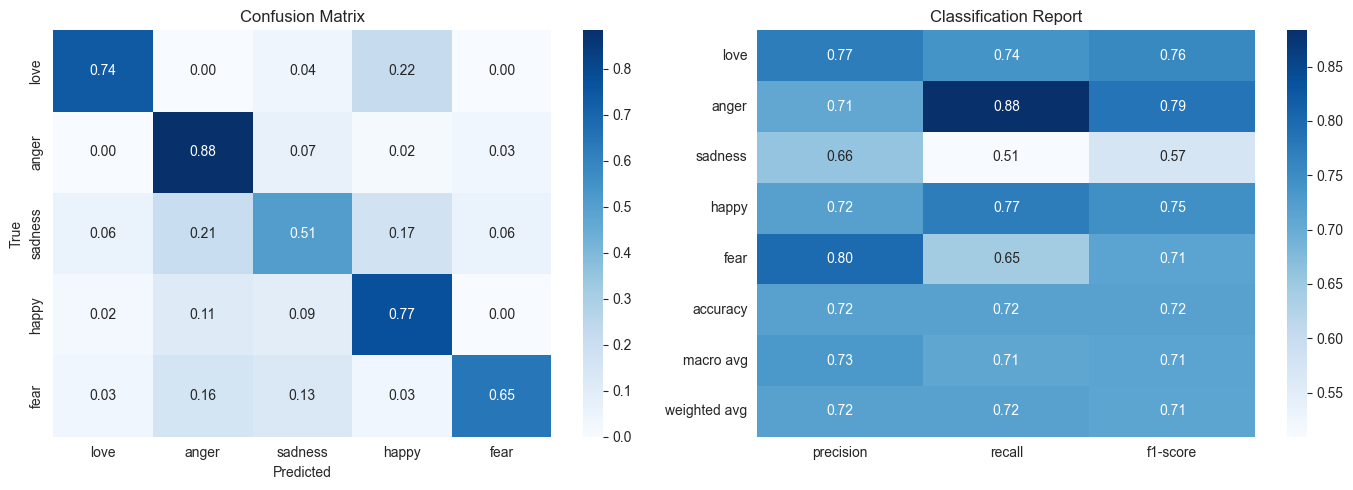


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/base_2pBT.pt
   → Detected base model: indobenchmark/indobert-base-p1


Evaluating base_2pBT.pt: 100%|██████████| 14/14 [00:42<00:00,  3.05s/it]


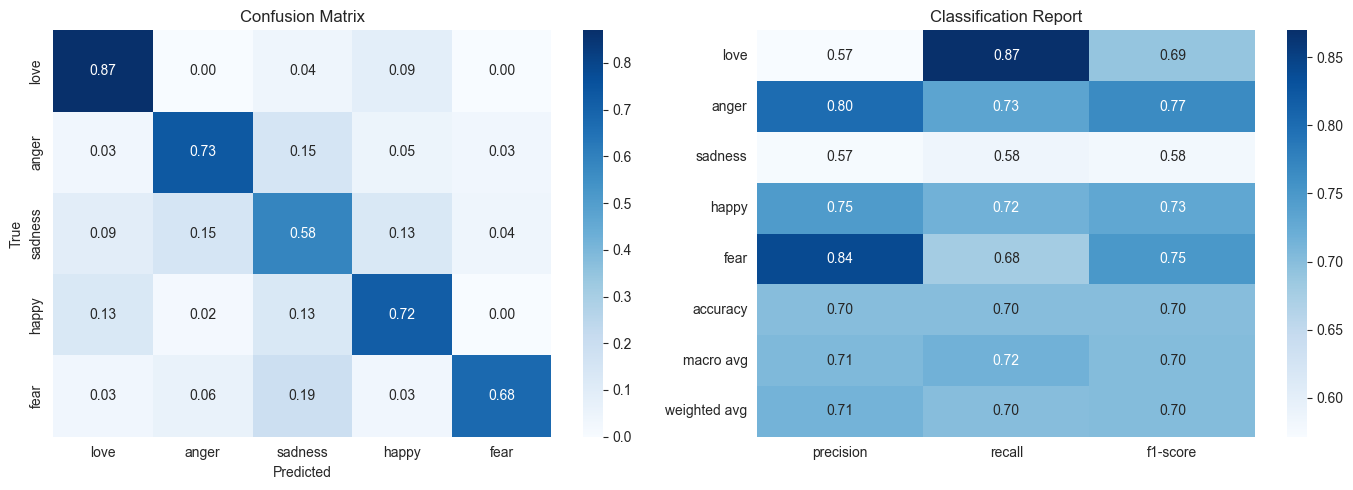


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/base_augment.pt
   → Detected base model: indobenchmark/indobert-base-p1


Evaluating base_augment.pt: 100%|██████████| 14/14 [00:43<00:00,  3.10s/it]


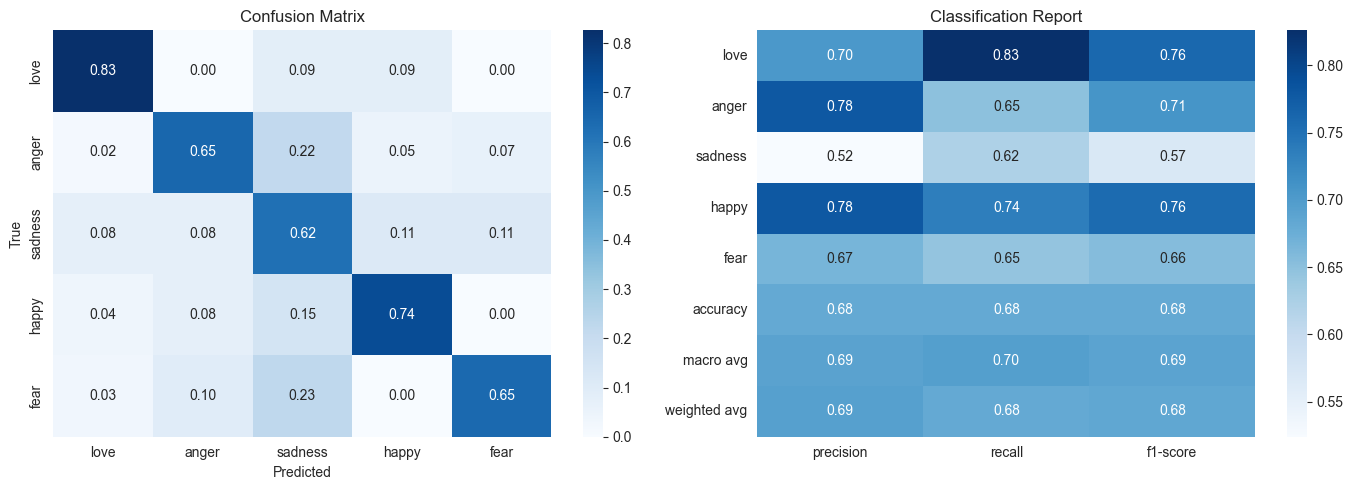


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/base_natural.pt
   → Detected base model: indobenchmark/indobert-base-p1


Evaluating base_natural.pt: 100%|██████████| 14/14 [00:48<00:00,  3.46s/it]


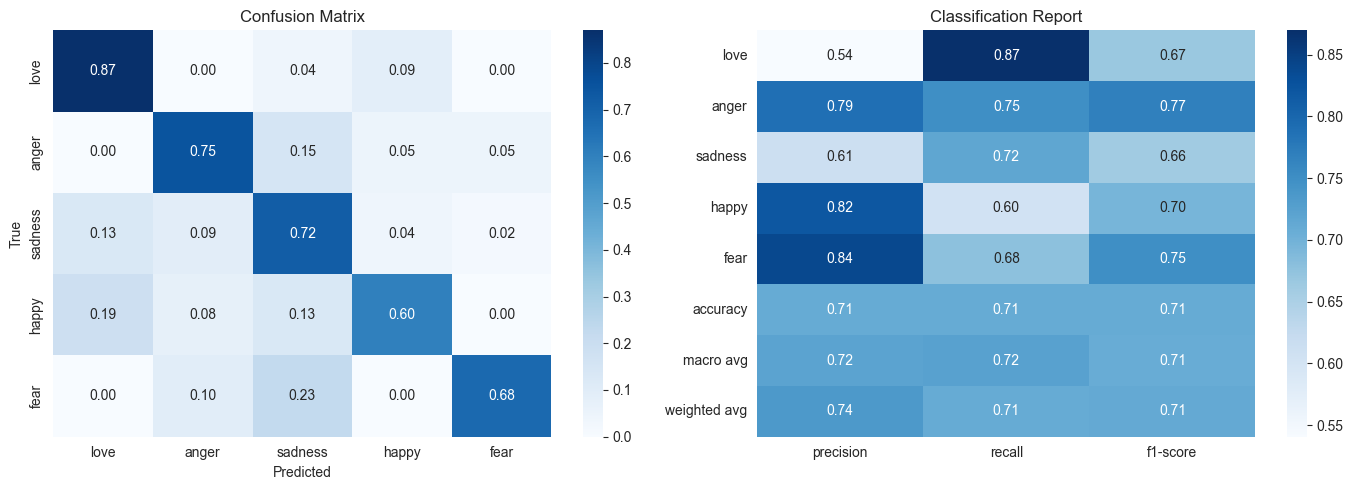


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/tweet_1pBT.pt
   → Detected base model: indolem/indobertweet-base-uncased


Evaluating tweet_1pBT.pt: 100%|██████████| 14/14 [01:02<00:00,  4.48s/it]


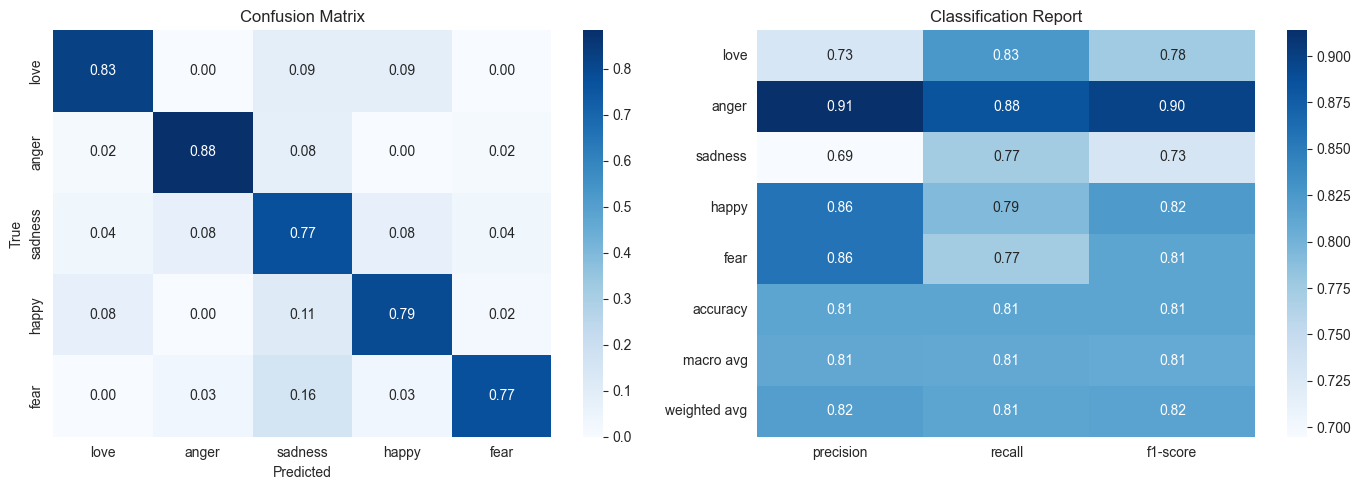


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/tweet_2pBT.pt
   → Detected base model: indolem/indobertweet-base-uncased


Evaluating tweet_2pBT.pt: 100%|██████████| 14/14 [00:59<00:00,  4.26s/it]


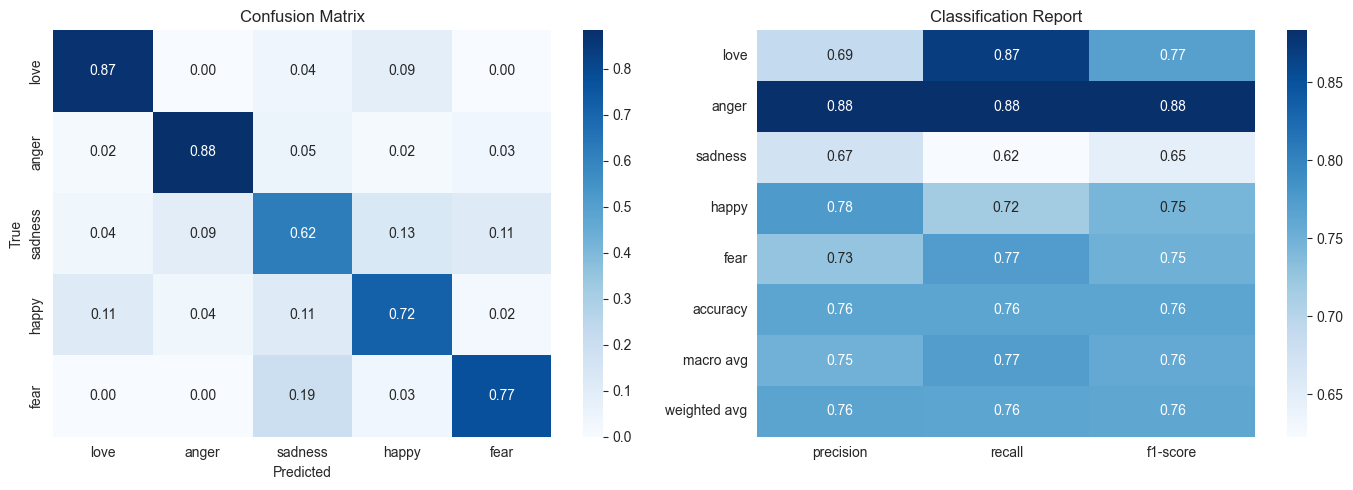


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/tweet_augment.pt
   → Detected base model: indolem/indobertweet-base-uncased


Evaluating tweet_augment.pt: 100%|██████████| 14/14 [00:48<00:00,  3.45s/it]


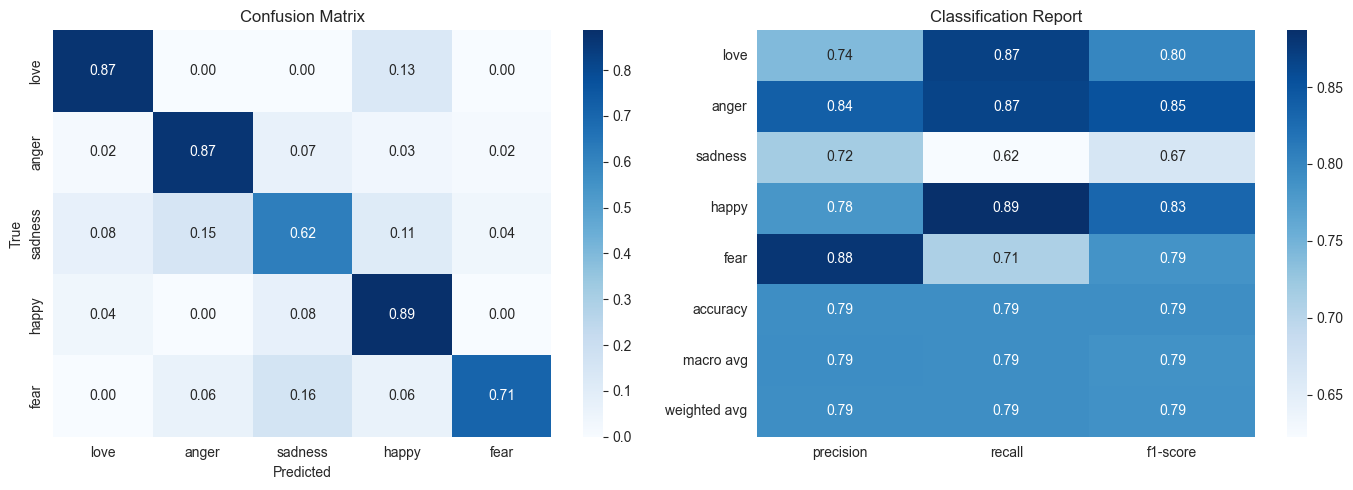


🔍 Loading model from: C:/Users/dvirl/PycharmProjects/SemanticAnalysis/resources/model_from_drive/tweet_natural.pt
   → Detected base model: indolem/indobertweet-base-uncased


Evaluating tweet_natural.pt: 100%|██████████| 14/14 [00:43<00:00,  3.13s/it]


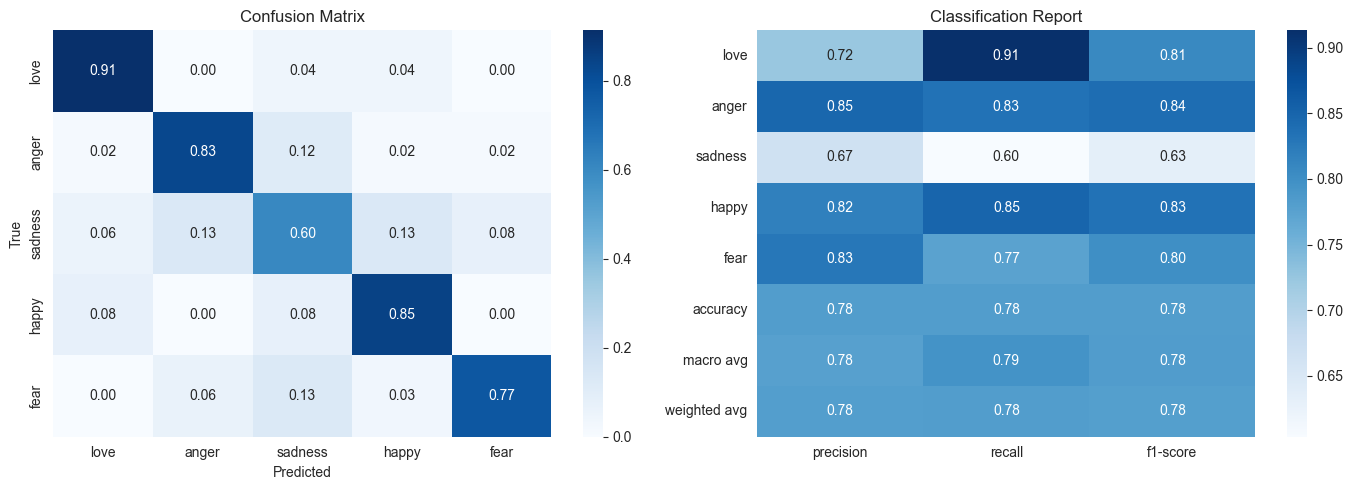

[{'model_name': 'base_1pBT.pt',
  'base_model': 'indobenchmark/indobert-base-p1',
  'accuracy': 0.7181818181818181,
  'f1_macro': 0.7149898171174768,
  'f1_weighted': 0.711762024779433},
 {'model_name': 'base_2pBT.pt',
  'base_model': 'indobenchmark/indobert-base-p1',
  'accuracy': 0.7,
  'f1_macro': 0.703016209364764,
  'f1_weighted': 0.7021189184017232},
 {'model_name': 'base_augment.pt',
  'base_model': 'indobenchmark/indobert-base-p1',
  'accuracy': 0.6818181818181818,
  'f1_macro': 0.690215136929676,
  'f1_weighted': 0.6847473551900171},
 {'model_name': 'base_natural.pt',
  'base_model': 'indobenchmark/indobert-base-p1',
  'accuracy': 0.7090909090909091,
  'f1_macro': 0.7084838350055741,
  'f1_weighted': 0.7119674166413297},
 {'model_name': 'tweet_1pBT.pt',
  'base_model': 'indolem/indobertweet-base-uncased',
  'accuracy': 0.8136363636363636,
  'f1_macro': 0.8086093759537715,
  'f1_weighted': 0.8154818591535228},
 {'model_name': 'tweet_2pBT.pt',
  'base_model': 'indolem/indobertwe

In [46]:

# ==== RUN COMPARISON ====
results = []
for fname in os.listdir(models_dir):
    if fname.endswith(".pt"):
        model_path = f'{models_dir}/{fname}'
        res = evaluate_model(model_path)
        results.append(res)
results

In [50]:

# ==== RESULTS SUMMARY ====
results_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False)
display(results_df)

,model_name,base_model,accuracy,f1_macro,f1_weighted
4,tweet_1pBT.pt,indolem/indobertweet-base-uncased,0.813636,0.808609,0.815482
6,tweet_augment.pt,indolem/indobertweet-base-uncased,0.790909,0.787340,0.787848
7,tweet_natural.pt,indolem/indobertweet-base-uncased,0.781818,0.783005,0.779763
5,tweet_2pBT.pt,indolem/indobertweet-base-uncased,0.763636,0.758944,0.762394
3,base_natural.pt,indobenchmark/indobert-base-p1,0.709091,0.708484,0.711967
0,base_1pBT.pt,indobenchmark/indobert-base-p1,0.718182,0.714990,0.711762
1,base_2pBT.pt,indobenchmark/indobert-base-p1,0.700000,0.703016,0.702119
2,base_augment.pt,indobenchmark/indobert-base-p1,0.681818,0.690215,0.684747


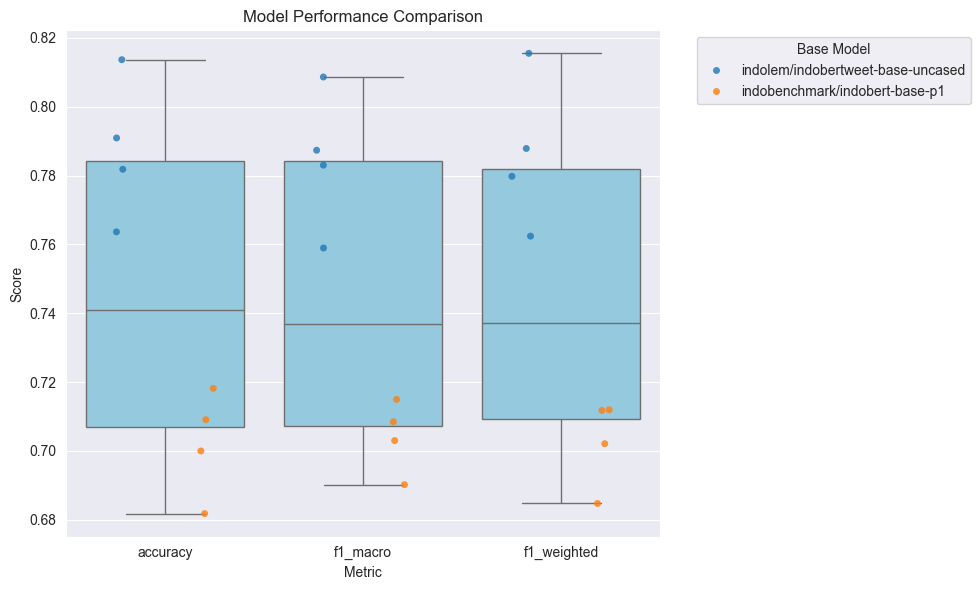

In [51]:


# ==== BOX PLOT FOR COMPARISON ====
plt.figure(figsize=(10, 6))
melted = results_df.melt(
    id_vars=['model_name', 'base_model'],
    value_vars=['accuracy', 'f1_macro', 'f1_weighted']
)
sns.boxplot(x='variable', y='value', data=melted, color='skyblue')
sns.stripplot(x='variable', y='value', data=melted, hue='base_model',
              dodge=True, marker='o', alpha=0.8)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Base Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [57]:

# ==== SAVE RESULTS ====
results_df.to_csv("model_comparison_results.csv", index=False)
print("✅ Results saved to model_comparison_results.csv")


✅ Results saved to model_comparison_results.csv
